# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting 
import numpy as np ### math computations
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset   
    

In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.as_numpy_iterator())[:2])
print(list(val_dataset.as_numpy_iterator())[:2])
print(list(test_dataset.as_numpy_iterator())[:2])

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1), (array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

# Data Visualizing

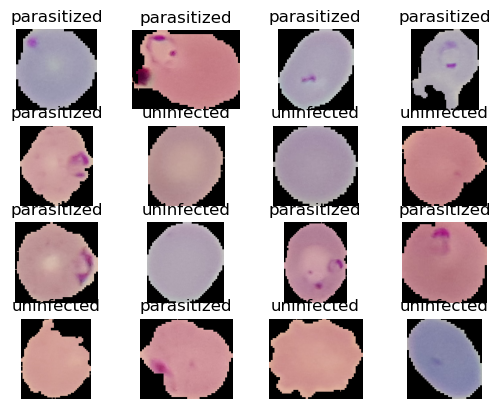

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
dataset_info.features['label'].int2str(0)

'parasitized'

# Data Preprocessing

In [10]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label 

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [13]:
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
val_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size= 8 , reshuffle_each_iteration= True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Sequential API

In [16]:
sequential_model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE,3)),
    
    Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Flatten(),
           
    Dense(units=100, activation='relu'),
    BatchNormalization(),
    
    Dense(units=10, activation='relu'),
    BatchNormalization(),
    
    Dense(units=1, activation='sigmoid') 
])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Functional API

In [17]:
input_func = Input(shape= (IM_SIZE, IM_SIZE,3))
input_func

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [18]:
x = Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu')(input_func)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=2)(x)

x = Flatten()(x)

x = Dense(units=100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(units=10, activation='relu')(x)
x = BatchNormalization()(x)

output = Dense(units=1, activation='sigmoid')(x)

In [19]:
functional_model = Model(input_func, output, name = 'funtional model')
functional_model.summary()

Model: "funtional model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16) 

# Model Subclassing

In [20]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)
        
        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)    
        
        return x

In [21]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2))

In [22]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation):
        super(LenetModel, self).__init__()
        
        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides, 
                                    padding = padding, 
                                    activation_function = activation_function, 
                                    pool_size = pool_size)
        self.flatten = Flatten()
        
        self.dense_1 = Dense(units = 100, activation=activation_function)
        self.batch_1 = BatchNormalization()

        self.dense_2 = Dense(units = 10, activation=activation_function)
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)
        
    def call(self, x, training):
        x = self.featureExtractor(x)
        x = self.flatten(x)

        x = self.dense_1(x)
        x = self.batch_1(x)
        
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)    
        
        return x

In [23]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), output_activation = "sigmoid")
lenet_model(Input(shape= (IM_SIZE, IM_SIZE,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 dense_6 (Dense)             multiple                  19009700  
                                                                 
 batch_normalization_12 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_13 (Bat  multiple                 

# Custom Layer

In [24]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation = activation
        
    def build(self, input_freature_shape):
        self.w = self.add_weight(shape = (input_freature_shape[-1], self.output_units), initializer= "random_normal", trainable=True)
        self.b = self.add_weight(shape = (self.output_units,), initializer="random_normal", trainable=True)
    
    def call(self, input_features):
        pre_output = tf.matmul(input_features, self.w) + self.b
        
        if (self.activation == "relu"):
            return tf.nn.relu(pre_output)
        elif(self.activation == "sigmoid"):
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output
        

In [25]:
custom_model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE,3)),
    
    Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Flatten(),
           
    CustomDenseLayer(output_units=100, activation='relu'),
    BatchNormalization(),
    
    CustomDenseLayer(output_units=10, activation='relu'),
    BatchNormalization(),
    
    CustomDenseLayer(output_units=1, activation='sigmoid') 
])
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_14 (Bat  (None, 222, 222, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_15 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

# Optimizers

In [26]:
custom_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics='accuracy')

# Train

In [27]:
history = custom_model.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose=1)

Epoch 1/20
689/689 [==============================] - 14s 16ms/step - loss: 0.5170 - accuracy: 0.7408 - val_loss: 4.9622 - val_accuracy: 0.5230
Epoch 2/20
689/689 [==============================] - 11s 16ms/step - loss: 0.2628 - accuracy: 0.9115 - val_loss: 1.7381 - val_accuracy: 0.4780
Epoch 3/20
689/689 [==============================] - 11s 16ms/step - loss: 0.2391 - accuracy: 0.9170 - val_loss: 0.8520 - val_accuracy: 0.5038
Epoch 4/20
689/689 [==============================] - 11s 16ms/step - loss: 0.2283 - accuracy: 0.9237 - val_loss: 2.7960 - val_accuracy: 0.5060
Epoch 5/20
689/689 [==============================] - 11s 16ms/step - loss: 0.1989 - accuracy: 0.9330 - val_loss: 0.9545 - val_accuracy: 0.5245
Epoch 6/20
689/689 [==============================] - 11s 16ms/step - loss: 0.1910 - accuracy: 0.9359 - val_loss: 1.5850 - val_accuracy: 0.4955
Epoch 7/20
689/689 [==============================] - 11s 16ms/step - loss: 0.1850 - accuracy: 0.9394 - val_loss: 0.5702 - val_accuracy:

# Loss

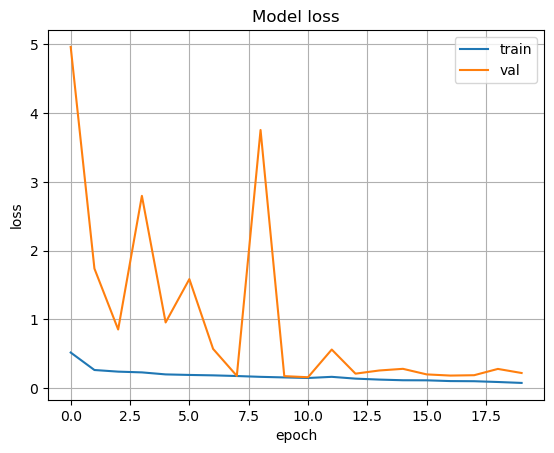

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

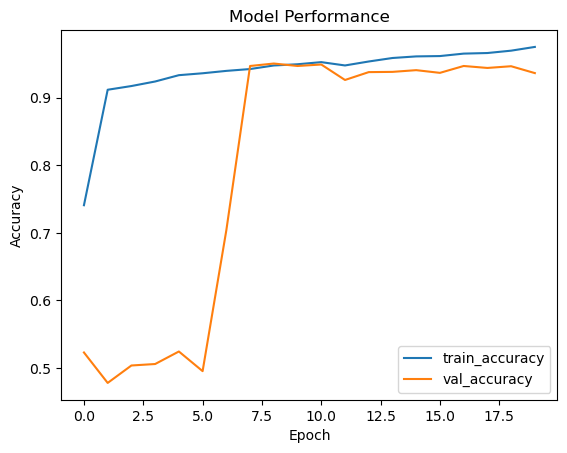

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [30]:
test_dataset

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [31]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [32]:
custom_model.evaluate(test_dataset)

2757/2757 [==============================] - 4s 1ms/step - loss: 0.2403 - accuracy: 0.9314


[0.24033592641353607, 0.9314472079277039]

# Predict

In [33]:
custom_model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 1s 561ms/step


0.9841636

In [34]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [35]:
parasite_or_not(custom_model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 1s 527ms/step


'P'

1/1 [==============================] - 0s 10ms/step


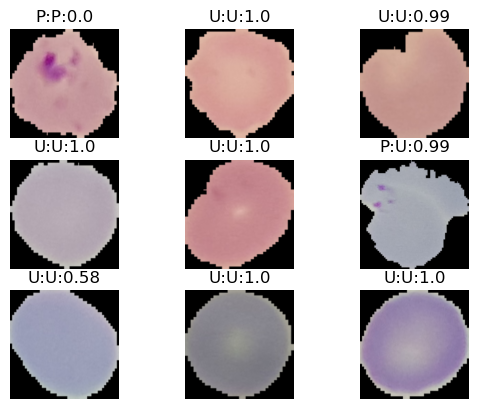

In [36]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    res = custom_model.predict(image)[0][0]
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
    plt.axis('off')